Installation and download to load basic packages

In [ ]:
!pip install findspark

In [ ]:
!pip install pyspark

     |████████████████████████████████| 281.4 MB 33 kB/s 
     |████████████████████████████████| 198 kB 48.5 MB/s 
  Created wheel for pyspark: filename=pyspark-3.2.1-py2.py3-none-any.whl size=281853642 sha256=6a2e22c155eb06f85ad3df0a7298886d2b6de2d84091e92f160db4d9ce2317e0
  Stored in directory: /root/.cache/pip/wheels/9f/f5/07/7cd8017084dce4e93e84e92efd1e1d5334db05f2e83bcef74f
Successfully built pyspark


In [ ]:
from io import StringIO
from PIL import Image
import numpy as np
import pyspark
import pandas as pd
import numpy as np
from os import listdir
from os.path import isfile, join
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import os
from pyspark import SparkContext
from pyspark.sql import SparkSession
from skimage.color import rgb2gray
#np.asarray(Image.open(StringIO(rawdata)))
from sklearn.decomposition import PCA

Creating the spark contect object that will run the big data

In [ ]:
spark = SparkSession.builder.appName("Faces").getOrCreate()

allowing access to local files in my drive and loading target labels

In [ ]:
import os

path = "/usr/tmp"

# Check current working directory.
retval = os.getcwd()
print ("Current working directory %s" % retval)



Current working directory /content


In [ ]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
mypath = "/content/drive/My Drive/Colab Notebooks/crop_part1/" #drive
filenames = np.array([f for f in listdir(mypath) if isfile(join(mypath, f))])
splitcolumns = [x.split('_')[0:3] + [mypath  + x] for x in filenames if x.count('_') == 3]
filecolumns = ['age','gender','race','file']
filedf = pd.DataFrame(data = splitcolumns, columns = filecolumns)
filedfnona = filedf.dropna()
filedfnona['age']  = filedfnona['age'].astype(int)
filedfnona['race'] = filedfnona['race'].astype(int)
filedfnona['gender'] = filedfnona['gender'].astype(int)

In [ ]:
filedfnona.head()

,age,gender,race,file
0,3,1,0,/content/drive/My Drive/Colab Notebooks/crop_p...
1,3,1,0,/content/drive/My Drive/Colab Notebooks/crop_p...
2,3,1,0,/content/drive/My Drive/Colab Notebooks/crop_p...
3,3,1,0,/content/drive/My Drive/Colab Notebooks/crop_p...
4,3,1,0,/content/drive/My Drive/Colab Notebooks/crop_p...


In [ ]:
filedfnona['file'][0]

'/content/drive/My Drive/Colab Notebooks/crop_part1/3_1_0_20170109192003664.jpg.chip.jpg'

In [ ]:
#listing = os.listdir(mypath) 
images = []
for img in filedfnona['file']:
    image = plt.imread(img)
    image = rgb2gray(image)
    images.append(image)

(200, 200)


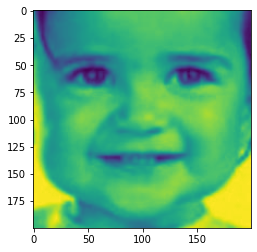

In [ ]:
plt.imshow(images[0])
print(images[0].shape)

In [ ]:
images5 = np.array(images)

In [ ]:
images5.shape

(9786, 200, 200)

In [ ]:
nsamples, nx, ny = images5.shape
pca_dataset = images5.reshape((nsamples,nx*ny))

In [ ]:
pca = PCA(n_components = 195)
images4 = pca.fit_transform(pca_dataset)
#X_test_pca = pca.transform(X_test)

In [ ]:
print(len(images4))
filedfnona['age']  = filedfnona['age'].astype(int)
filedfnona['race'] = filedfnona['race'].astype(int)
filedfnona['gender'] = filedfnona['gender'].astype(int)

9786


In [54]:
img_dict = {}
i = 0
for img_ in images4:
  img_dict[i] = [img_, filedfnona['age'][i], filedfnona['race'][i], filedfnona['gender'][i]]
  i+=1

In [60]:
img_labels = []
i=0
for img_ in images4:
  tupp = (img_, filedfnona['age'][i], filedfnona['race'][i], filedfnona['gender'][i])
  img_labels.append(tupp)

In [61]:
img_labels[0]

(array([ 3.01614885e+01,  3.88508272e+00,  1.14600842e+01,  1.44229499e+01,
         1.21641546e+00, -9.48760186e+00,  3.62462321e+00, -4.06481665e+00,
         2.52433880e+00,  6.64859130e-01, -2.44277170e+00,  7.04044111e-01,
         5.49178259e+00,  1.71201052e+00, -3.32275519e+00,  5.23514603e+00,
        -4.54651503e+00,  1.32709580e+00,  1.50769568e+00,  4.08192486e+00,
        -1.98293919e+00,  4.46265952e-01,  1.73372407e+00,  7.63672948e-01,
        -3.46916061e+00, -3.49299877e+00,  3.10348637e+00,  4.34619898e+00,
         3.22713172e+00,  1.47325591e+00,  5.14171614e-01,  1.09695784e+00,
         3.08017709e+00,  2.21245929e+00, -1.73261750e+00, -2.68394832e+00,
         1.61507109e+00, -8.02538568e-01,  1.17358273e+00, -2.80888708e+00,
         5.76840273e-02, -5.95528231e-01,  3.35976360e+00,  1.73496296e+00,
        -9.02761702e-01, -1.86686922e+00,  1.92333724e-01, -1.23782491e+00,
        -9.72541778e-01, -2.72549341e+00,  5.40160521e-01, -4.34619052e-01,
        -2.0

In [55]:
len(img_dict)

9786

In [62]:
sc = SparkContext.getOrCreate()
img_t = sc.parallelize(img_labels)

In [63]:
img_t.take(1)

[(array([ 3.01614885e+01,  3.88508272e+00,  1.14600842e+01,  1.44229499e+01,
          1.21641546e+00, -9.48760186e+00,  3.62462321e+00, -4.06481665e+00,
          2.52433880e+00,  6.64859130e-01, -2.44277170e+00,  7.04044111e-01,
          5.49178259e+00,  1.71201052e+00, -3.32275519e+00,  5.23514603e+00,
         -4.54651503e+00,  1.32709580e+00,  1.50769568e+00,  4.08192486e+00,
         -1.98293919e+00,  4.46265952e-01,  1.73372407e+00,  7.63672948e-01,
         -3.46916061e+00, -3.49299877e+00,  3.10348637e+00,  4.34619898e+00,
          3.22713172e+00,  1.47325591e+00,  5.14171614e-01,  1.09695784e+00,
          3.08017709e+00,  2.21245929e+00, -1.73261750e+00, -2.68394832e+00,
          1.61507109e+00, -8.02538568e-01,  1.17358273e+00, -2.80888708e+00,
          5.76840273e-02, -5.95528231e-01,  3.35976360e+00,  1.73496296e+00,
         -9.02761702e-01, -1.86686922e+00,  1.92333724e-01, -1.23782491e+00,
         -9.72541778e-01, -2.72549341e+00,  5.40160521e-01, -4.34619052e-01,

In [ ]:
def adaptistEqualizer(imagesArray):
  from skimage import exposure
  img_adapteq = exposure.equalize_adapthist(imagesArray, clip_limit=0.03)   
  return img_adapteq 

In [64]:
def sobelChannel(img):
  from skimage.exposure import rescale_intensity
  from skimage import filters
  from skimage.color.adapt_rgb import adapt_rgb, each_channel, hsv_value
  @adapt_rgb(each_channel)
  def sobel_each(img):
    return filters.sobel(img)
    
  image = rescale_intensity(1 - sobel_each(img[0]))
  return image, img[1], img[1], img[2]

In [65]:
sobel = img_t.map(sobelChannel)

In [66]:
sobel.take(2)

[(array([ 1.        ,  0.58847475, -1.        ,  0.12899342,  0.87147083,
         -0.55834198, -0.72211419, -0.36773699, -0.68445981, -0.15766487,
         -0.42964066, -0.85857046, -0.48227141,  0.05135337, -0.61891239,
         -0.36102897, -0.21520018, -0.75641749, -0.57717279, -0.237877  ,
         -0.22999832, -0.62942612, -0.44475556, -0.14485602, -0.1962607 ,
         -0.78458245, -0.85339005, -0.43422912, -0.27143419, -0.28012555,
         -0.40706881, -0.56691462, -0.48811344, -0.16604835, -0.16150593,
         -0.60938093, -0.52972275, -0.40352724, -0.31851346, -0.36688871,
         -0.54775647, -0.60690314, -0.55411989, -0.1959427 , -0.23183601,
         -0.48700485, -0.4616858 , -0.36422796, -0.34669166, -0.50969207,
         -0.55196764, -0.28652376, -0.59291705, -0.53075338, -0.30518249,
         -0.38349902, -0.40621421, -0.51853355, -0.5232634 , -0.487351  ,
         -0.33190666, -0.28922077, -0.42367868, -0.46794732, -0.53196712,
         -0.45924408, -0.25049088, -0.

In [68]:
def split_age(item):
  return item[0], item[1]

In [69]:
agerddSobel = sobel.map(split_age)

In [70]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [76]:
#data = spark.read.format("libsvm").load("data/mllib/sample_libsvm_data.txt")

# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="label", outputCol="indexedLabel").fit(agerddSobel)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =VectorIndexer(inputCol="features", outputCol="indexedFeatures", maxCategories=4).fit(agerddSobel)

AttributeError: ignored

In [72]:
(trainingData, testData) = agerddSobel.randomSplit([0.7, 0.3])

In [71]:
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="indexedFeatures", numTrees=10)


In [ ]:
model = RandomForest.trainClassifier(trainingData, numClasses=2, categoricalFeaturesInfo={},
                                     numTrees=3, featureSubsetStrategy="auto",
                                     impurity='gini', maxDepth=4, maxBins=32)
